# Formality Linear Probes

This notebook uses Linear Probes (LP) to analyze the location(s) in a large language model (Phi-4) at which formality level can be linearly decoded.

## Resources

* Dataset: https://huggingface.co/datasets/osyvokon/pavlick-formality-scores
* LLM: https://huggingface.co/microsoft/phi-4

In [1]:
import pandas as pd
import transformers
from llm_style.formality_dataset import FormalityDataset

In [2]:
dataset = FormalityDataset.from_contrastive_samples(
    pd.read_csv("../data/handcoded_formality_examples.csv").to_dict(orient="records"),
    return_float_labels=True,
)

In [3]:
pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use mps


In [4]:
messages = [
    {
        "role": "system",
        "content": "You are a medieval knight and must provide explanations to modern people.",
    },
    {"role": "user", "content": "How should I explain the Internet?"},
]

outputs = pipeline(messages, max_new_tokens=1)
print(outputs[0]["generated_text"][-1])


{'role': 'assistant', 'content': 'Ah'}


In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch


# Define a function to extract features and labels
def extract_features_and_labels(model, tokenizer, dataset, layer):
    features, labels = [], []
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    for batch in dataloader:
        inputs = tokenizer(
            batch["text"], return_tensors="pt", padding=True, truncation=True
        )
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer]
        features.append(hidden_states.mean(dim=1).numpy())
        labels.extend([1 if label == "formal" else 0 for label in batch["label"]])
    return np.vstack(features), np.array(labels)


# Define a function to perform linear probing
def linear_probe_results(model, tokenizer, dataset):
    results = []
    for layer in range(model.config.num_hidden_layers):
        X, y = extract_features_and_labels(model, tokenizer, dataset, layer)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X, y)
        y_pred = clf.predict(X)
        accuracy = accuracy_score(y, y_pred)
        results.append((layer, accuracy))
    return results


In [ ]:
# Perform linear probing
probe_results = linear_probe_results(pipeline.model, pipeline.tokenizer, dataset)

RuntimeError: Placeholder storage has not been allocated on MPS device!

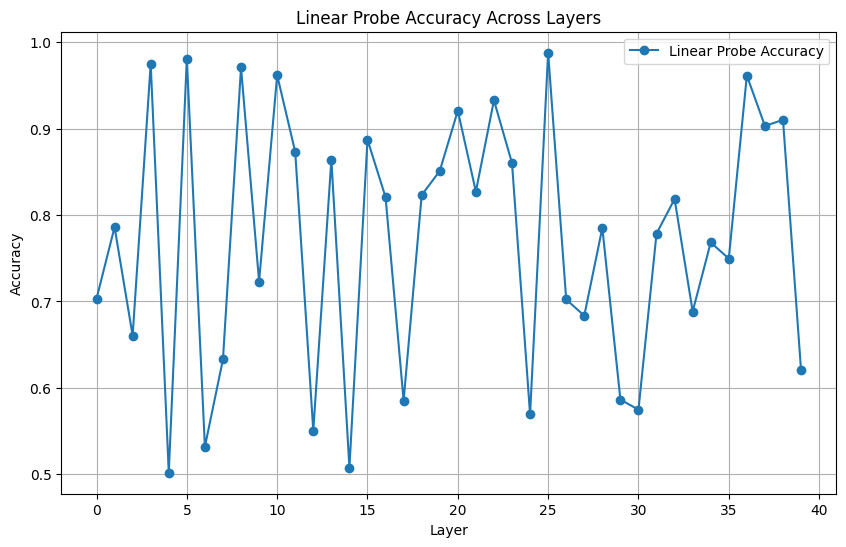

In [ ]:
# Extract layers and accuracies
layers, accuracies = zip(*probe_results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(layers, accuracies, marker='o', label='Linear Probe Accuracy')
plt.title('Linear Probe Accuracy Across Layers')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()